In [5]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Set default model file
MODEL_FILE = 'models.pkl'

# Load dataset
df = pd.read_csv('car_price.csv')
print("Kolom dataset:", df.columns.tolist())
df.head()

Kolom dataset: ['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner']


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [6]:
def train_and_save(
    df: pd.DataFrame,
    target_col: str = 'selling_price',
    test_size: float = 0.2,
    random_state: int = 42,
    n_clusters: int = 3,
    model_file: str = MODEL_FILE
):
    # Validasi
    if target_col not in df.columns:
        raise ValueError(f"Kolom '{target_col}' tidak ditemukan")
    
    # Pisah target & fitur
    y = df[target_col]
    X = df.drop(columns=[target_col])
    
    # Encode kategorikal
    encoders = {}
    for col in X.select_dtypes(include=['object', 'category']):
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        encoders[col] = le
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Regression
    reg = LinearRegression()
    reg.fit(X_train_s, y_train)
    y_pred = reg.predict(X_test_s)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Regression RMSE: {rmse:.2f}")
    
    # Plot residuals
    residuals = y_test - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals)
    plt.axhline(0)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.show()
    
    # Classification (High vs Low)
    median_val = y.median()
    y_cls = (y > median_val).astype(int)
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(
        X, y_cls, test_size=test_size, random_state=random_state
    )
    Xc_train_s = scaler.transform(Xc_train)
    Xc_test_s = scaler.transform(Xc_test)
    
    clf = RandomForestClassifier(random_state=random_state)
    clf.fit(Xc_train_s, yc_train)
    yc_pred = clf.predict(Xc_test_s)
    acc = accuracy_score(yc_test, yc_pred)
    print(f"Classification Accuracy: {acc:.2f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(yc_test, yc_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low','High'])
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()
    
    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(X_train_s)
    print("Cluster centers:\n", kmeans.cluster_centers_)
    
    # 2D scatter (ambil dua fitur numerik contoh: year & km_driven)
    if 'year' in X.columns and 'km_driven' in X.columns:
        plt.figure()
        plt.scatter(X_train_s[:, X.columns.get_loc('year')],
                    X_train_s[:, X.columns.get_loc('km_driven')],
                    c=clusters)
        plt.xlabel("Year (scaled)")
        plt.ylabel("KM Driven (scaled)")
        plt.title("Cluster Visualization")
        plt.show()
    
    # Simpan artefak
    joblib.dump({
        'reg': reg,
        'clf': clf,
        'scaler': scaler,
        'encoders': encoders,
        'kmeans': kmeans,
        'median_val': median_val,
        'target_col': target_col
    }, model_file)
    print(f"Artefak disimpan ke '{model_file}'")
    
    # Return test splits for inspection
    return X_test, y_test, y_pred, yc_test, yc_pred

Regression RMSE: 429339.12


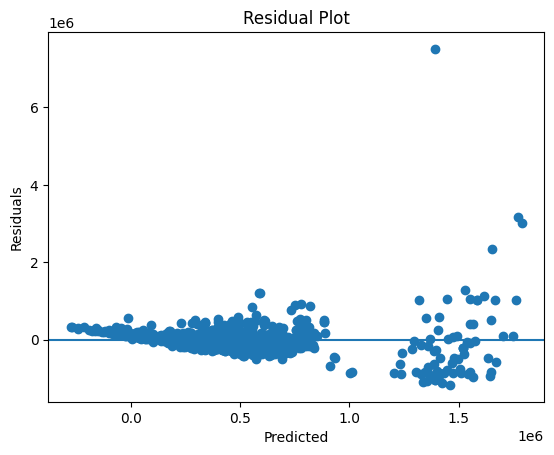

Classification Accuracy: 0.89


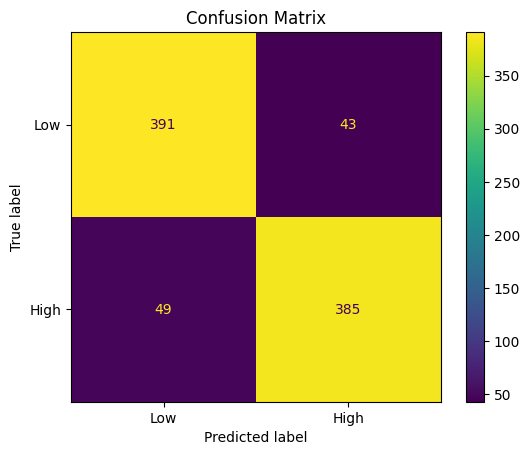

Cluster centers:
 [[-0.23057643  0.44120058 -0.36785861 -0.11271709 -0.53298395 -2.92655741
  -0.24027764]
 [ 0.2091168  -0.83911652  0.7241035  -0.05397852  0.34146481  0.33378495
   0.87507675]
 [-0.09401399  0.47027931 -0.40829425  0.05737188 -0.1234387   0.3416984
  -0.53268561]]


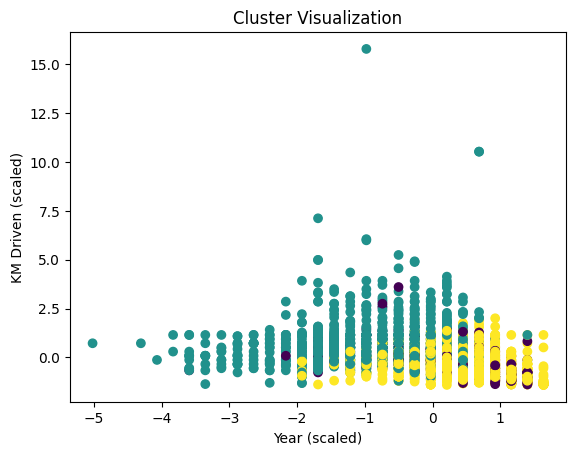

Artefak disimpan ke 'models.pkl'


In [7]:
X_test, y_test, y_pred, yc_test, yc_pred = train_and_save(
    df,
    target_col='selling_price',
    test_size=0.2,
    n_clusters=3
)

In [8]:
def predict_new(
    df_new: pd.DataFrame,
    model_file: str = MODEL_FILE
) -> pd.DataFrame:
    art = joblib.load(model_file)
    reg, clf = art['reg'], art['clf']
    scaler, encoders = art['scaler'], art['encoders']
    kmeans, median_val = art['kmeans'], art['median_val']
    target_col = art['target_col']
    
    Xn = df_new.copy()
    for col, le in encoders.items():
        if col not in Xn.columns:
            raise KeyError(f"Kolom '{col}' hilang")
        Xn[col] = le.transform(Xn[col].astype(str))
    
    Xn_s = scaler.transform(Xn)
    df_new[f'predicted_{target_col}'] = reg.predict(Xn_s)
    df_new['price_label'] = (df_new[f'predicted_{target_col}'] > median_val).astype(int)
    df_new['cluster'] = kmeans.predict(Xn_s)
    return df_new

In [9]:

sample_new = df.drop(columns=['selling_price']).head(5)
sample_pred = predict_new(sample_new)
sample_pred


,name,year,km_driven,fuel,seller_type,transmission,owner,predicted_selling_price,price_label,cluster
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner,41502.666479,0,1
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner,52381.503038,0,1
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner,493845.930021,1,2
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner,460710.455779,1,2
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner,506024.015713,1,1


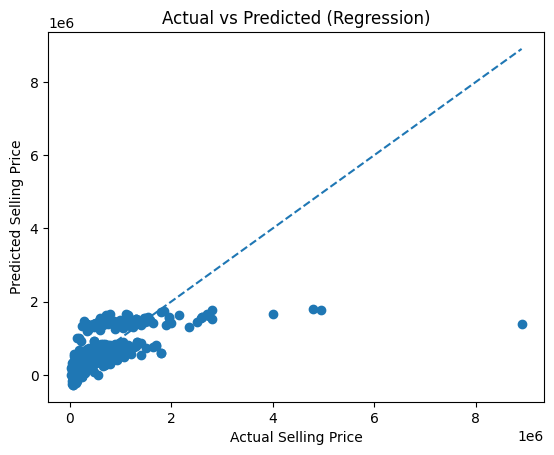

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted (Regression)")
plt.show()


In [11]:
import pandas as pd

comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
comparison.head(10)


,Actual,Predicted
0,165000,4.129916e+05
1,250000,5.176095e+05
2,120000,8.946554e+04
3,450000,5.060240e+05
4,730000,1.553074e+06
5,155000,2.491583e+05
6,530000,4.382573e+05
7,92800,2.809462e+05
8,284000,6.583330e+05
9,260000,2.988897e+05


In [12]:
comp_cls = pd.DataFrame({
    'Actual Label': yc_test.values,
    'Predicted Label': yc_pred
})
comp_cls.head(10)


,Actual Label,Predicted Label
0,0,0
1,0,1
2,0,0
3,1,1
4,1,1
5,0,0
6,1,1
7,0,0
8,0,1
9,0,0


In [13]:
import pickle

filename = 'car_price_model.sav'
pickle.dump(sample_pred, open(filename, 'wb'))

In [14]:
df = pd.read_csv('car_price.csv')
art = joblib.load('models.pkl')
scaler   = art['scaler']
encoders = art['encoders']
kmeans   = art['kmeans']

In [15]:
df_enc = df.copy()
for col, le in encoders.items():
    df_enc[col] = le.transform(df_enc[col].astype(str))

In [16]:
feature_cols = [c for c in df_enc.columns if c != 'selling_price']
Xs_all = scaler.transform(df_enc[feature_cols])

In [17]:
df['cluster'] = kmeans.predict(Xs_all)

In [18]:
print(df.groupby('cluster')[['year','km_driven','selling_price']]
      .mean().round(1))

           year  km_driven  selling_price
cluster                                  
0        2015.0    48630.5      1418689.2
1        2009.6   100407.1       256295.4
2        2015.1    46908.1       494984.7


In [19]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, silhouette_score
import numpy as np
import pandas as pd
import joblib

# --- Persiapan ulang data untuk evaluasi ---
df = pd.read_csv('car_price.csv')
art = joblib.load('models.pkl')
reg = art['reg']
clf = art['clf']
scaler = art['scaler']
encoders = art['encoders']
kmeans = art['kmeans']
target_col = art['target_col']
median_val = art['median_val']

# Pisahkan fitur dan target
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode kategori
for col, le in encoders.items():
    X[col] = le.transform(X[col].astype(str))

# Scaling
X_scaled = scaler.transform(X)

# --- 1. Evaluasi Model Regresi ---
y_pred_reg = reg.predict(X_scaled)
r2 = r2_score(y, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y, y_pred_reg))

print("📈 [REGRESSION MODEL]")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# --- 2. Evaluasi Model Klasifikasi ---
y_label = clf.predict(X_scaled)
y_true = (y > median_val).astype(int)

accuracy = accuracy_score(y_true, y_label)
print("\n📊 [CLASSIFICATION MODEL]")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_true, y_label))

# --- 3. Evaluasi Clustering ---
cluster_labels = kmeans.predict(X_scaled)
sil_score = silhouette_score(X_scaled, cluster_labels)

print("\n🔍 [CLUSTERING MODEL]")
print(f"Silhouette Score: {sil_score:.4f}")


📈 [REGRESSION MODEL]
R² Score: 0.4496
RMSE: 429171.83

📊 [CLASSIFICATION MODEL]
Accuracy: 0.9776
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2174
           1       0.98      0.98      0.98      2166

    accuracy                           0.98      4340
   macro avg       0.98      0.98      0.98      4340
weighted avg       0.98      0.98      0.98      4340


🔍 [CLUSTERING MODEL]
Silhouette Score: 0.2235
